In [1]:
import torch
import gpytorch
import numpy as np
from scipy import stats
from joblib import Parallel, delayed
from multiprocessing import cpu_count

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import emcee
import numpy.linalg as la
from getdist import plots, MCSamples, parampriors
from joblib import Parallel, delayed, cpu_count
from multiprocessing import cpu_count, Pool
import time
# from chainconsumer import ChainConsumer

# **BIN 5**

## Datavectors

### Load fiducial

In [4]:
fid = np.load('/Users/atersenov/Data/l1_validation/sim_datavectors/bin5/fid_a/new_l1_norms_fid_a_f_theta15.0_bin5.npy', allow_pickle=True)
# fid = np.load('/Users/atersenov/Data/l1_validation/sim_datavectors/bin5/fid_a/new_l1_norms_fid_a_theta15.0_bin5.npy', allow_pickle=True)

In [5]:
fid.shape

(20, 800)

In [6]:
rebinning_factor = 10

In [7]:
fid_rebinned = fid.reshape(fid.shape[0], -1, rebinning_factor).mean(axis=2)
fid_rebinned_mean = fid_rebinned.mean(axis=0)

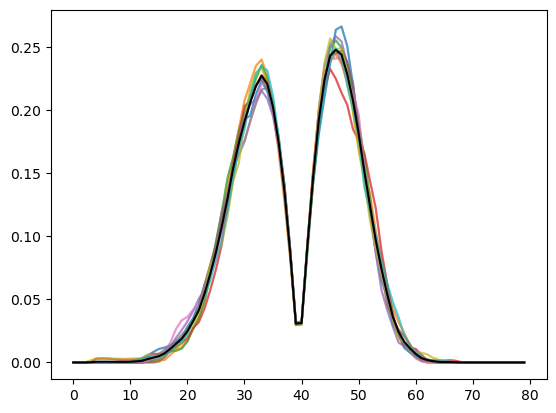

In [8]:
for i in range(fid_rebinned.shape[0]):
    plt.plot(fid_rebinned[i], alpha=0.5)
plt.plot(fid_rebinned_mean, label='Mean', color='k')

### Load all l1 theory predictions

In [9]:
cosmo_slics = np.load('/Users/atersenov/Downloads/filtertophat_results_15_tomobin5_simulationTrue.npy', allow_pickle=True).item()
cosmo_new = np.load('/Users/atersenov/Downloads/filtertophat_results_15_tomobin5_simulationFalse.npy', allow_pickle=True).item()

In [10]:
# Extract all slics arrays into a list
slics_l1 = [cosmo_slics[i]['prediction_l1'] for i in range(len(cosmo_slics))]
sim = [cosmo_slics[i]['sim_l1_runs'] for i in range(len(cosmo_slics))]
slics_sigma = [cosmo_slics[i]['perturbation_theory_sigma_sq'] for i in range(len(cosmo_slics))]
snr = cosmo_slics[0]['snr'] 

# Extract all new arrays into a list
new_l1 = [cosmo_new[i]['prediction_l1'] for i in range(len(cosmo_new))]
new_sigma = [cosmo_new[i]['perturbation_theory_sigma_sq'] for i in range(len(cosmo_new))]

In [11]:
# Convert to a NumPy array
slics_l1 = np.stack(slics_l1)  
sim = np.stack(sim)
slics_sigma = np.stack(slics_sigma)
new_l1 = np.stack(new_l1)
new_sigma = np.stack(new_sigma)

In [12]:
sim_std_per_cosmo = np.std(sim, axis=1)

(-5.0, 5.0)

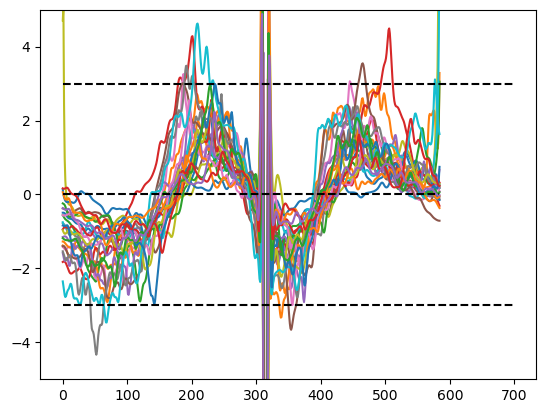

In [29]:
for i in range(slics_l1.shape[0]):
    plt.plot( (slics_l1[i][85:670] - np.mean(sim[i], axis=0)[85:670])/sim_std_per_cosmo[i][85:670], label=f'Slics {i+1}')
plt.plot(np.zeros_like(slics_l1[0][85:670]), label='Zero line', color='k', ls='--')
plt.plot(3*np.ones_like(slics_l1[0][50:750]), color='k', ls='--')
plt.plot(-3*np.ones_like(slics_l1[0][50:750]), color='k', ls='--')
plt.ylim(-5, 5)

In [ ]:
full_long_cov = np.cov(cov_l1_dv, rowvar=False)

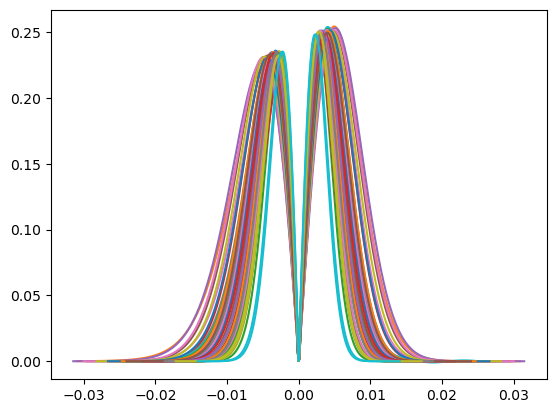

In [33]:
for i in range(slics_l1.shape[0]):
    plt.plot(snr * np.sqrt(slics_sigma[i]), slics_l1[i], label=f'Slics {i+1}')
for i in range(new_l1.shape[0]):
    plt.plot(snr * np.sqrt(new_sigma[i]), new_l1[i], label=f'New {i+1}')

### Rebin predictions and SNR

In [34]:
slics_l1_rebinned = slics_l1.reshape(slics_l1.shape[0], -1, rebinning_factor).mean(axis=2)
snr_rebinned = snr.reshape(-1, rebinning_factor).mean(axis=1)

new_l1_rebinned = new_l1.reshape(new_l1.shape[0], -1, rebinning_factor).mean(axis=2)

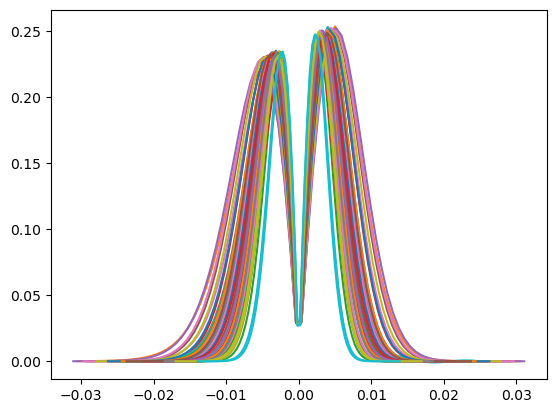

In [35]:
for i in range(slics_l1_rebinned.shape[0]):
    plt.plot(snr_rebinned * np.sqrt(slics_sigma[i]), slics_l1_rebinned[i], label=f'Prediction {i+1}')
for i in range(new_l1_rebinned.shape[0]):
    plt.plot(snr_rebinned * np.sqrt(new_sigma[i]), new_l1_rebinned[i], label=f'Prediction {i+1}')

## Covariance

Load datavectors

In [36]:
cov_l1_dv = np.load('/Users/atersenov/Downloads/new_cov_l1_norms_theta15.0_bin5.npy', allow_pickle=True)
cov_sigma = np.load('/Users/atersenov/Downloads/new_cov_sigma_values_theta15.0_bin5.npy', allow_pickle=True)

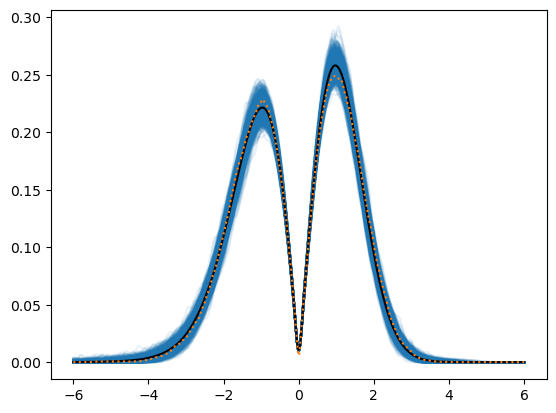

In [37]:
for i in range(cov_l1_dv.shape[0]):
    plt.plot(snr , cov_l1_dv[i], label=f'Covariance {i+1}', color='C0', alpha=0.1)
plt.plot(snr , np.mean(cov_l1_dv, axis=0), label='Mean of Simulations',  color='black')
plt.plot(snr, np.mean(fid, axis=0), label='Fiducial', color='C1', ls=':',)

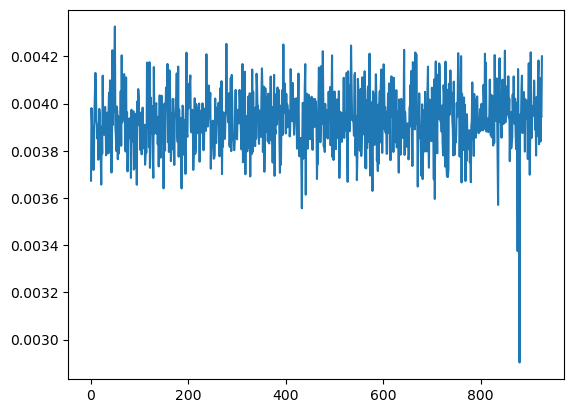

In [41]:
plt.plot(cov_sigma)

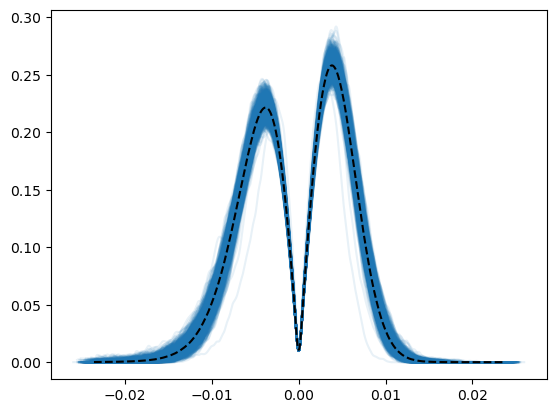

In [38]:
for i in range(cov_l1_dv.shape[0]):
    plt.plot(snr * cov_sigma[i], cov_l1_dv[i], label=f'Covariance {i+1}', color='C0', alpha=0.1)
plt.plot(snr * np.mean(cov_sigma, axis=0), np.mean(cov_l1_dv, axis=0), label='Mean of Simulations', ls='--', color='black')

### Rebin covariance datavectors

In [42]:
cov_l1_dv_rebinned = cov_l1_dv.reshape(cov_l1_dv.shape[0], -1, rebinning_factor).mean(axis=2)
rebinned_snr = snr.reshape(-1, rebinning_factor).mean(axis=1)

Text(0.5, 0, 'SNR')

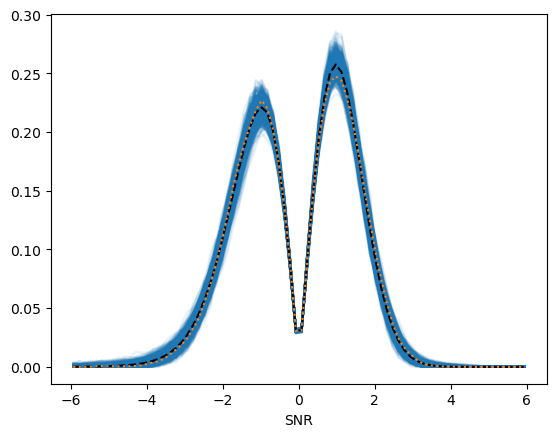

In [43]:
for i in range(cov_l1_dv_rebinned.shape[0]):
    plt.plot(rebinned_snr, cov_l1_dv_rebinned[i], label=f'Covariance {i+1}', color='C0', alpha=0.1)
plt.plot(rebinned_snr, np.mean(cov_l1_dv_rebinned, axis=0), label='Mean of Simulations', ls='--', color='black')

plt.plot(rebinned_snr, np.mean(fid_rebinned, axis=0), label='Fiducial', color='C1', ls=':')

plt.xlabel('SNR')

Calculate covariance matrix

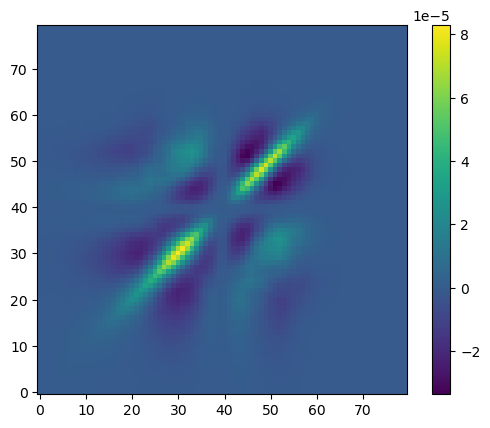

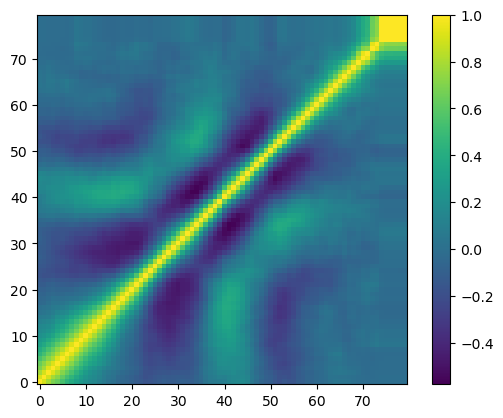

In [44]:
covariance_matrix = np.cov(cov_l1_dv_rebinned, rowvar=False)
correlation_matrix = np.corrcoef(cov_l1_dv_rebinned, rowvar=False)

plt.imshow(covariance_matrix, cmap='viridis', interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()

plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()

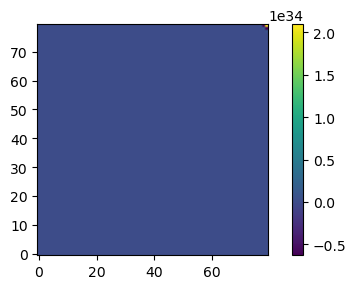

In [45]:
cov = covariance_matrix
icov = la.inv(cov)

plt.figure(figsize=(6,3))
plt.imshow(icov, origin='lower') #, vmin=0,vmax=5000)
plt.colorbar()

In [46]:
cov_diag = np.diag(cov)
cov_diag.shape

(80,)

## Creating arrays for cosmological parameters and l1 data vectors

SLICS cosmologies

In [49]:
# Read the CosmoTable.dat and parse into a dictionary
cosmo_table_path = './../example/CosmoTable.dat'
cosmo_params = {}

with open(cosmo_table_path, 'r') as file:
    lines = file.readlines()[1:]  # Skip the header


for line in lines:
    parts = line.split()
    cosmo_id = int(parts[0])
    # ignore the last column (i.e. the Oc parameter)
    parameters = [float(param) for param in parts[1:]]
    cosmo_params[cosmo_id] = parameters

# Initialize the params array based on the cosmo_params dictionary
params = np.array([cosmo_params[cosmo_id] for cosmo_id in range(25)])

In [50]:
# remove last column (that corresponds to Oc)
params = params[:,:-1]

New cosmologies

In [51]:
# Desired parameter order
param_order = ["Om", "h", "w", "sigma8"]

# Extract parameters into a list of lists
params_new = np.array([
    [float(entry["cosmology"][param]) for param in param_order]
    for entry in cosmo_new.values()
])

Concatenate SLICS and new cosmologies

In [55]:
# concatenate SLICS and new cosmologies
params_full = np.concatenate((params, params_new), axis=0)
l1_rebinned = np.concatenate((slics_l1_rebinned, new_l1_rebinned), axis=0)
sigma_full = np.concatenate((slics_sigma, new_sigma), axis=0)

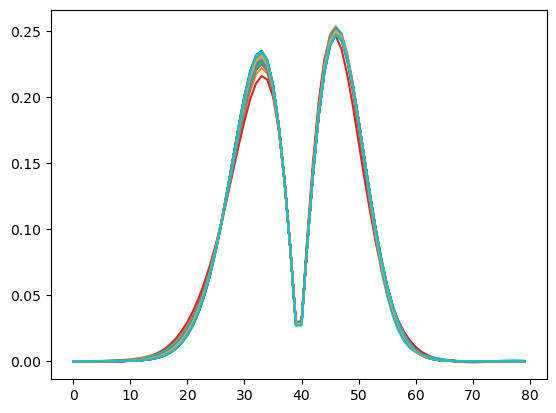

In [53]:
for i in range(50):
    plt.plot(l1_rebinned[i], label=f'Prediction {i+1}')

In [54]:
print(params[:,0].min(),params[:,0].max())
print(params[:,1].min(), params[:,1].max())
print(params[:,2].min(), params[:,2].max())
print(params[:,3].min(), params[:,3].max())

0.1019 0.5482
0.6034 0.8129
-1.9866 -0.5223
0.4716 1.3428


## GPR for sigma

In [48]:
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler        # or MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    ConstantKernel as C, RBF, WhiteKernel
)
from joblib import Parallel, delayed

In [311]:
# X = params_full.astype(float)
# y = np.sqrt(sigma_full).astype(float)

X = params_new.astype(float)
y = np.sqrt(new_sigma).astype(float)

In [312]:
x_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)

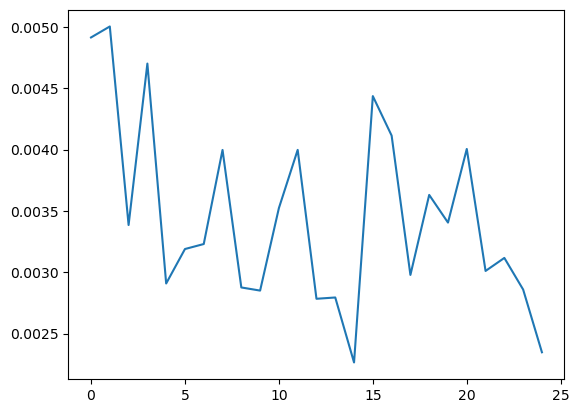

In [313]:
plt.plot(y, color='C0')

In [314]:
def fit_sigma(X_train, y_train, meas_var):
    """
    Fit a GP on the provided subset (X_train, y_train) for a single bin.
    """

    kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=np.ones(X_train.shape[1]), length_scale_bounds=(0.01, 100))
    
    gp = GaussianProcessRegressor(
        kernel=kernel,
        # alpha=np.full(len(y_train), meas_var),   # length matches subset
        normalize_y=True,
        n_restarts_optimizer=10,
        random_state=42,
    )
    gp.fit(X_train, y_train)
    return gp

In [315]:
gp_sigma = fit_sigma(X_scaled, y, meas_var=1.0)

In [316]:
print(gp_sigma.kernel_)

4.1**2 * RBF(length_scale=[6.83, 11.6, 14.9, 7.43])


In [317]:
def predict_sigma(cosmology):
    """
    Predict the sigma value for a given cosmology using the fitted GP model.
    """
    x_scaled = x_scaler.transform(np.array(cosmology).reshape(1, -1))  # Reshape to 2D array
    mean, std = gp_sigma.predict(x_scaled, return_std=True)
    return mean[0], std[0]

In [318]:
test_cosmo = np.array([0.3, 0.67, -1.0, 0.8]) 
mean, std = predict_sigma(test_cosmo)
print(f"mean = {mean}, std = {std}")

mean = 0.003657600599111429, std = 1.791904056039647e-06


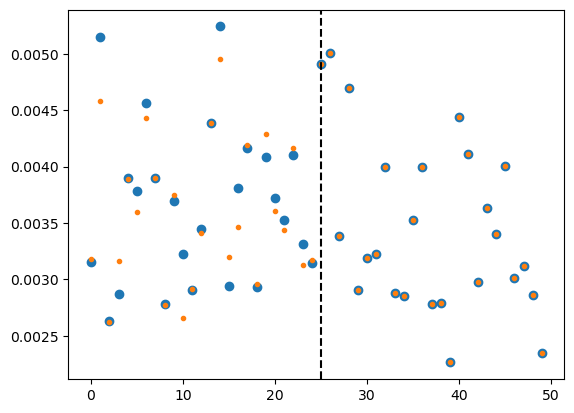

In [ ]:
plt.plot(np.sqrt(sigma_full), 'o', label='Theory', color='C0')

for i in range(50):
    mean, std = predict_sigma(params_full[i])
    plt.plot(i, mean, '.', label=f'GPR Prediction {i+1}', color='C1')

plt.axvline(x=25, color='k', ls='--', label='New Cosmologies')

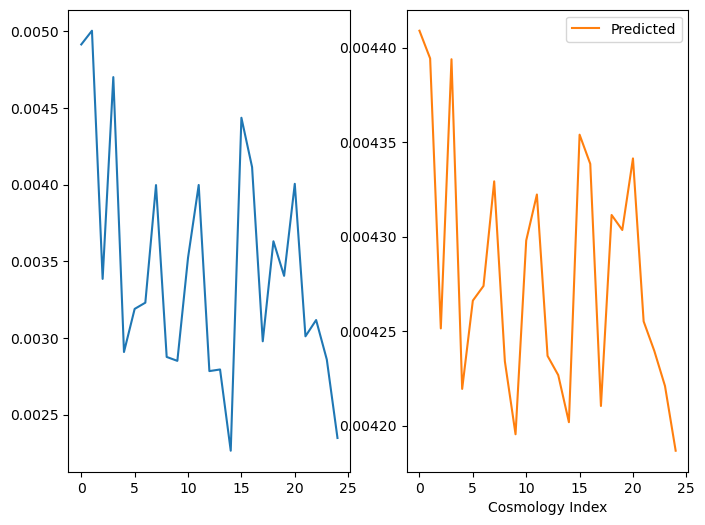

In [335]:
plt.figure(figsize=(8, 6))
plt.subplot(1,2,1)

# plot in the first subplot the y values and in the second subplot the predictions
plt.plot(y, label='Observed', color='C0')
plt.subplot(1,2,2)
plt.plot(gp_sigma.predict(X, return_std=False), label='Predicted', color='C1')
plt.xlabel('Cosmology Index')
plt.legend()

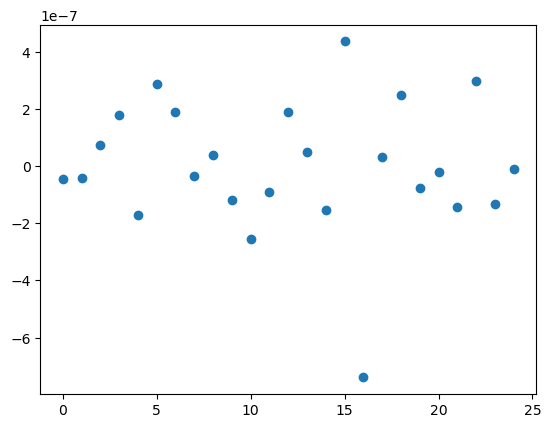

In [328]:
for i in range(y.shape[0]):
    plt.plot(i, (y[i] - predict_sigma(params_full[i+25])[0]) * 100 / y[i], 'o', label=f'Prediction {i+1}', color='C0')

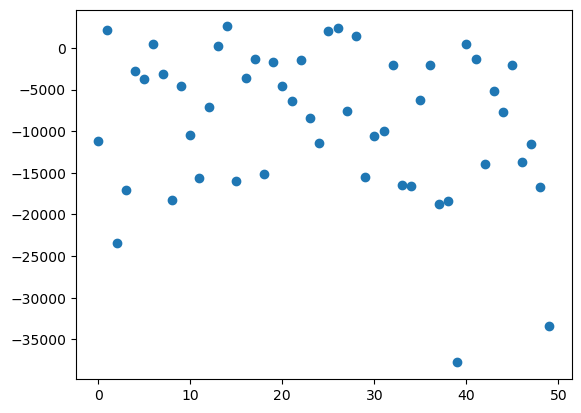

In [329]:
plt.plot( (np.sqrt(sigma_full) - gp_sigma.predict(params_full, return_std=False)) * 100 / sigma_full, 'o')
# plt.ylim(-10, 10)

<ErrorbarContainer object of 3 artists>

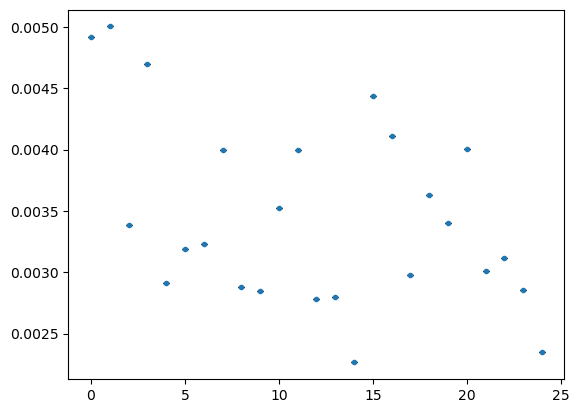

In [330]:
plt.errorbar(
    np.arange(len(y)), 
    y, 
    yerr=std,
    ecolor='k',
    capsize=2,
    fmt='.'
)

## GPR for l1

1. Data

In [162]:
X = params_full.astype(float)        # (50, 4)
Y = l1_rebinned.astype(float)        # (50, 40)
noise_per_bin = np.sqrt(cov_diag).astype(float)  # (40,)

In [163]:
Y.shape

(50, 80)

2. Scale the cosmological parameters

In [164]:
x_scaler = StandardScaler()
# x_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = x_scaler.fit_transform(X)

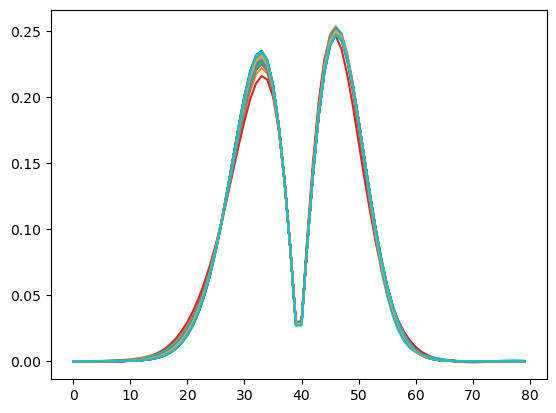

In [165]:
for i in range(Y.shape[0]):
    plt.plot(Y[i])

In [166]:
low_bin_cut = 10
up_bin_cut = 60
Y_cut = Y[:, low_bin_cut:up_bin_cut]

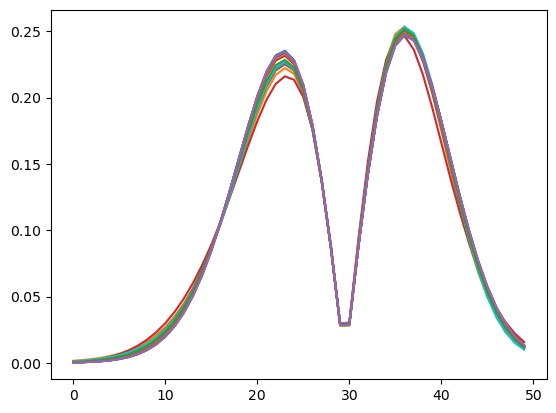

In [167]:
for i in range(25):
    plt.plot(Y_cut[i], label=f'{i}')

In [168]:
noise_per_bin_cut = noise_per_bin[low_bin_cut:up_bin_cut]

3. Train 40 independent scalar GPs

In [169]:
# # --- 1. Slightly tweaked helper -------------------------------------------
def fit_one_bin(X_train, y_train, meas_var):
    """
    Fit a GP on the provided subset (X_train, y_train) for a single bin.
    """
    # kernel = (
    #     C(1.0, (1e-3, 1e3))
    #     * RBF(length_scale=np.ones(X_train.shape[1]), length_scale_bounds=(1e-2, 1e2))
    #     + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-2, 1e0))
    # )

    kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=np.ones(X_train.shape[1]), length_scale_bounds=(0.01, 100))
    

    gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=np.full(len(y_train), meas_var),   # length matches subset
        normalize_y=True,
        n_restarts_optimizer=10,
        random_state=42,
    )
    gp.fit(X_train, y_train)
    return gp

In [170]:
gp_models = Parallel(n_jobs=-1, verbose=10)(
    delayed(fit_one_bin)(X_scaled, Y_cut[:, i], 0.001 * noise_per_bin_cut[i]) for i in range(Y_cut.shape[1])
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:    3.7s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:    3.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:    3.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.9s finished


In [171]:
print(gp_models[0].kernel_)

1.48**2 * RBF(length_scale=[19.9, 2.13, 4.66, 0.607])


4. Convenience prediction wrapper

In [172]:
def predict_l1norm(cosmology, return_var=True):
    """
    Predict 40-bin l1-norm for an arbitrary cosmology.
    • cosmology : array-like (4,) in the *original* parameter units.
    • return_var : if True, also return predictive variances (shape (40,)).
    """
    x_scaled = x_scaler.transform(np.asarray(cosmology, dtype=float).reshape(1, -1))
    means, vars_ = [], []
    for gp in gp_models:
        if return_var:
            mu, std = gp.predict(x_scaled, return_std=True)
            means.append(mu.item())
            vars_.append(std.item() ** 2)
        else:
            means.append(gp.predict(x_scaled)[0])
    means = np.array(means)
    return (means, np.array(vars_)) if return_var else means

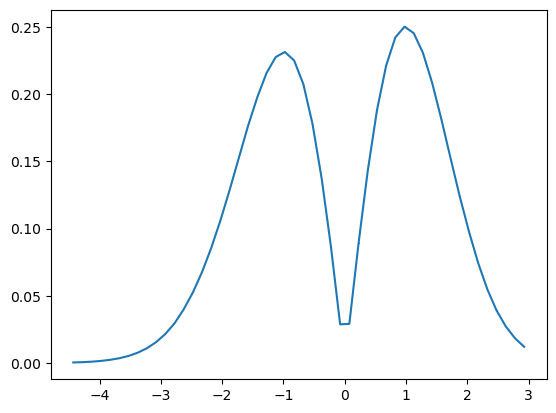

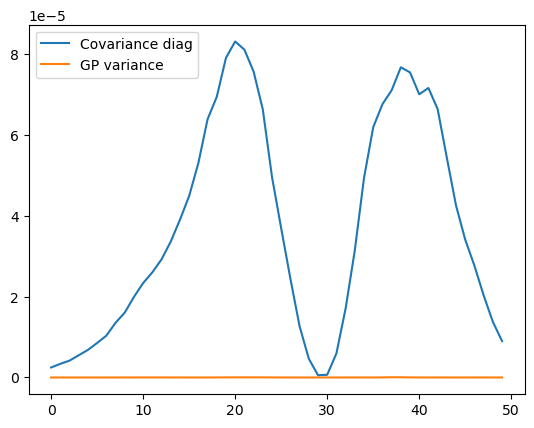

In [173]:
test_cosmo = np.array([0.3, 0.67, -1.0, 0.8])   # Ω_m, h, w_0, s_8
mu, var = predict_l1norm(test_cosmo)
plt.errorbar(snr_rebinned[low_bin_cut:up_bin_cut], mu, yerr=np.sqrt(var), label='Predicted mean')
plt.show()

plt.plot(np.diag(cov[low_bin_cut:up_bin_cut, low_bin_cut:up_bin_cut]), label='Covariance diag')
plt.plot(var, label='GP variance')
plt.legend()
plt.show()

In [174]:
cov_aug = cov[low_bin_cut:up_bin_cut, low_bin_cut:up_bin_cut] + np.diag(var)
icov_aug = la.inv(cov_aug)

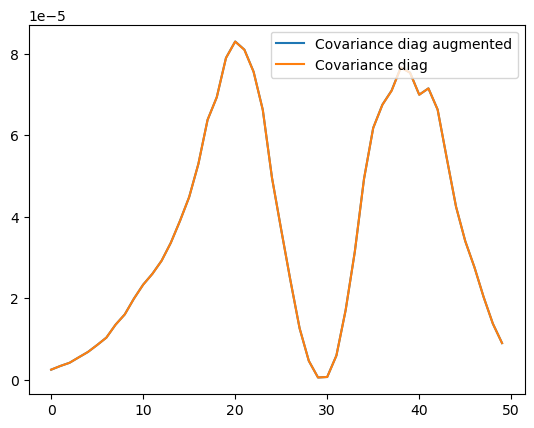

In [175]:
plt.plot(np.diag(cov_aug), label='Covariance diag augmented')
plt.plot(np.diag(cov[low_bin_cut:up_bin_cut, low_bin_cut:up_bin_cut]), label='Covariance diag')
plt.legend()

Text(0.5, 1.0, 'Predicted histograms for all the cosmologies')

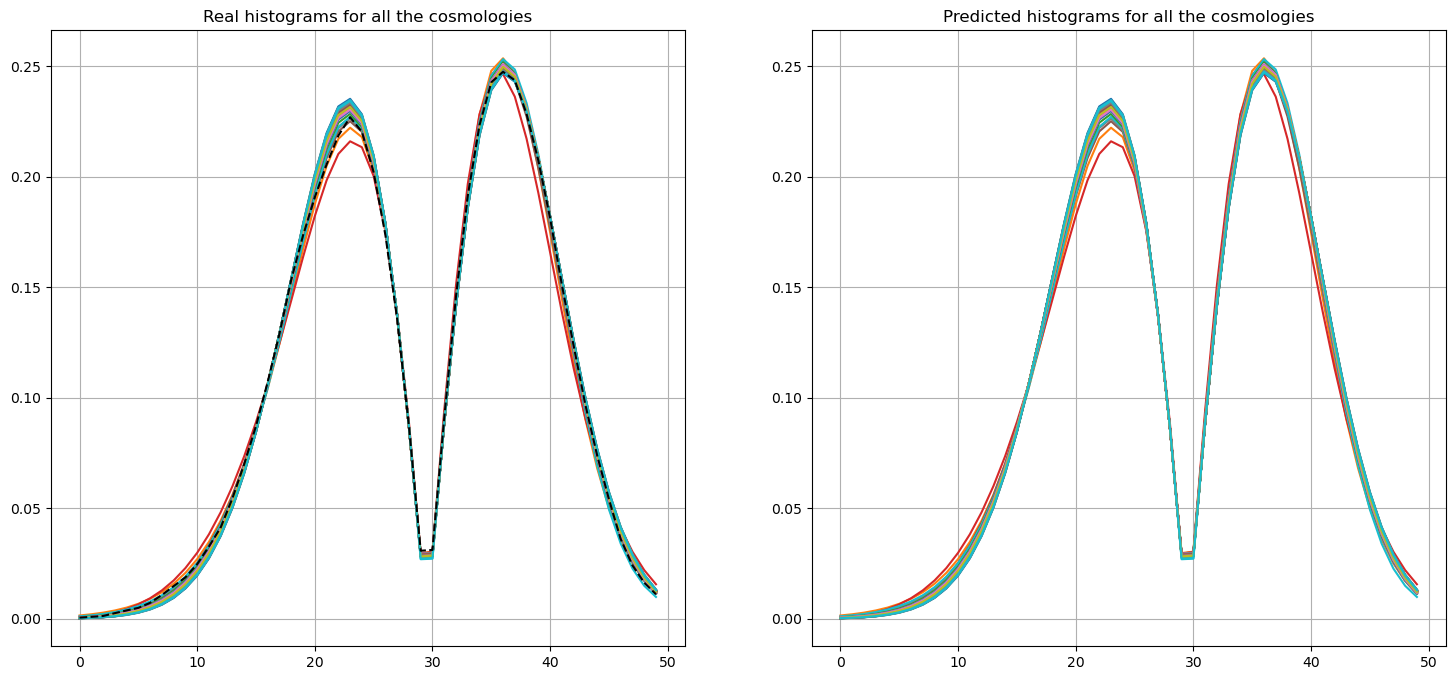

In [176]:
# plot in one subplot the real histograms for all the cosmologies and in another one the ones predicted by GPR
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)

for i in range(50):
    plt.plot(Y_cut[i], label=f'{i}')
# plt.plot(predict_l1norm([0.2905, 0.6898, -1., 0.8364])[0], label='pred fid', color='black')
# plt.errorbar(x=np.arange(low_param_cut, param_cut), y=test_fid_mean[0], yerr=np.sqrt(test_fid_mean[1]), color='black')
plt.plot(fid_rebinned_mean[low_bin_cut:up_bin_cut], label='sim fid', color='black', linestyle='--')
plt.grid()
plt.title('Real histograms for all the cosmologies')

plt.subplot(1,2,2)
for i in range(50):
    test_cosmo = predict_l1norm(params_full[i])[0]
    plt.plot(test_cosmo, label=f'{i}')
plt.grid()
plt.title('Predicted histograms for all the cosmologies')

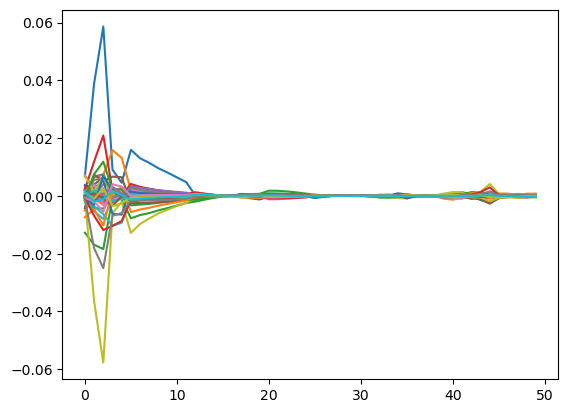

In [177]:
for i in range(Y_cut.shape[0]):
    plt.plot((Y_cut[i]-predict_l1norm(params_full[i])[0]) * 100/Y_cut[i], label=f'{i}')

<ErrorbarContainer object of 3 artists>

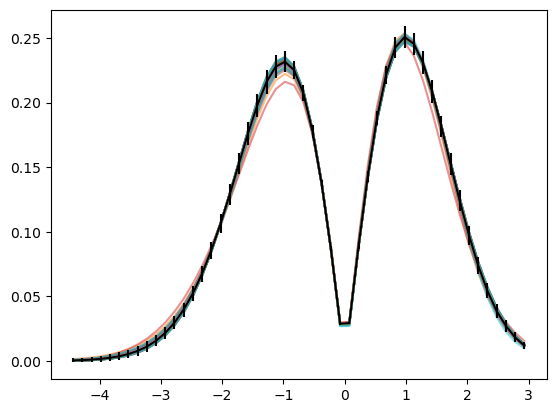

In [178]:
for i in range(50):
    plt.plot(snr_rebinned[low_bin_cut:up_bin_cut], Y_cut[i], label=f'{i}', alpha=0.5)
plt.errorbar(snr_rebinned[low_bin_cut:up_bin_cut], predict_l1norm([0.2905, 0.6898, -1., 0.8364])[0], yerr=np.sqrt(cov_diag[low_bin_cut:up_bin_cut]), label='pred fid', color='black')

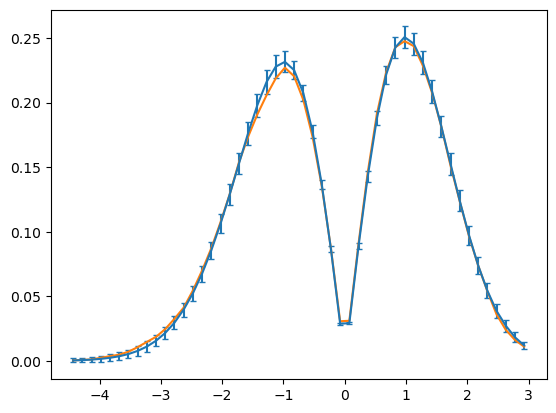

In [179]:
plt.errorbar(snr_rebinned[low_bin_cut:up_bin_cut], predict_l1norm([0.2905, 0.6898, -1., 0.8364])[0], yerr=np.sqrt(cov_diag[low_bin_cut:up_bin_cut]), label='pred fid', capsize=2)
plt.plot(snr_rebinned[low_bin_cut:up_bin_cut], fid_rebinned_mean[low_bin_cut:up_bin_cut], label='sim fid', color='C1')

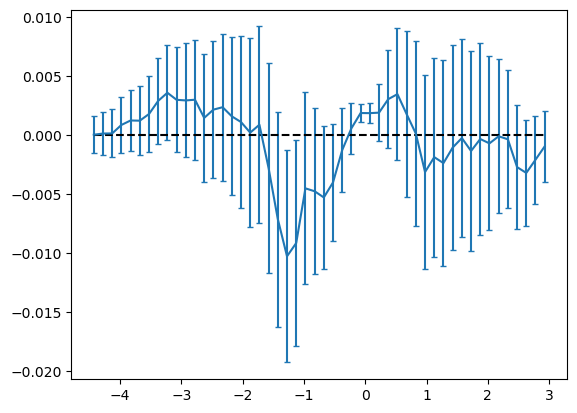

In [180]:
plt.errorbar(snr_rebinned[low_bin_cut:up_bin_cut], fid_rebinned_mean[low_bin_cut:up_bin_cut] - predict_l1norm([0.2905, 0.6898, -1., 0.8364])[0], yerr=np.sqrt(cov_diag[low_bin_cut:up_bin_cut]), label='pred fid', capsize=2)
plt.plot(snr_rebinned[low_bin_cut:up_bin_cut], np.zeros_like(snr_rebinned[low_bin_cut:up_bin_cut]), label='Zero line', color='k', ls='--')

## Combine GP and sigma predictions

In [331]:
# np.sqrt(sigma_full[49]), gp_sigma.predict(params_full[49], return_std=False)

gp_sigma.predict(params_full[49].reshape(1, -1)), np.sqrt(sigma_full[49]), predict_sigma(params_full[49])[0]

(array([0.00418669]),
 np.float64(0.0023476591062779975),
 np.float64(0.002347659106486842))

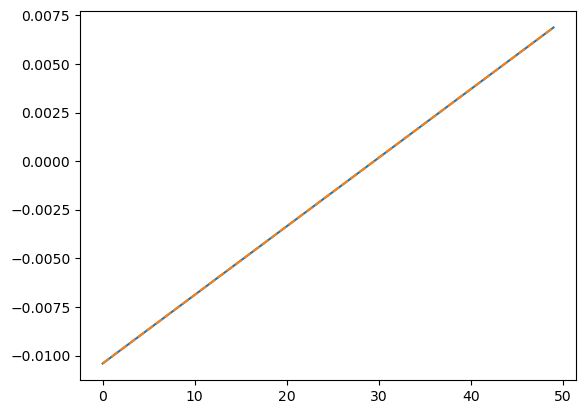

In [332]:
plt.plot(snr_rebinned[low_bin_cut:up_bin_cut] * np.sqrt(sigma_full[49]))
plt.plot(snr_rebinned[low_bin_cut:up_bin_cut] * predict_sigma(params_full[49])[0], label='Predicted Sigma', ls='--')

Text(0.5, 1.0, 'Predicted histograms for all the cosmologies')

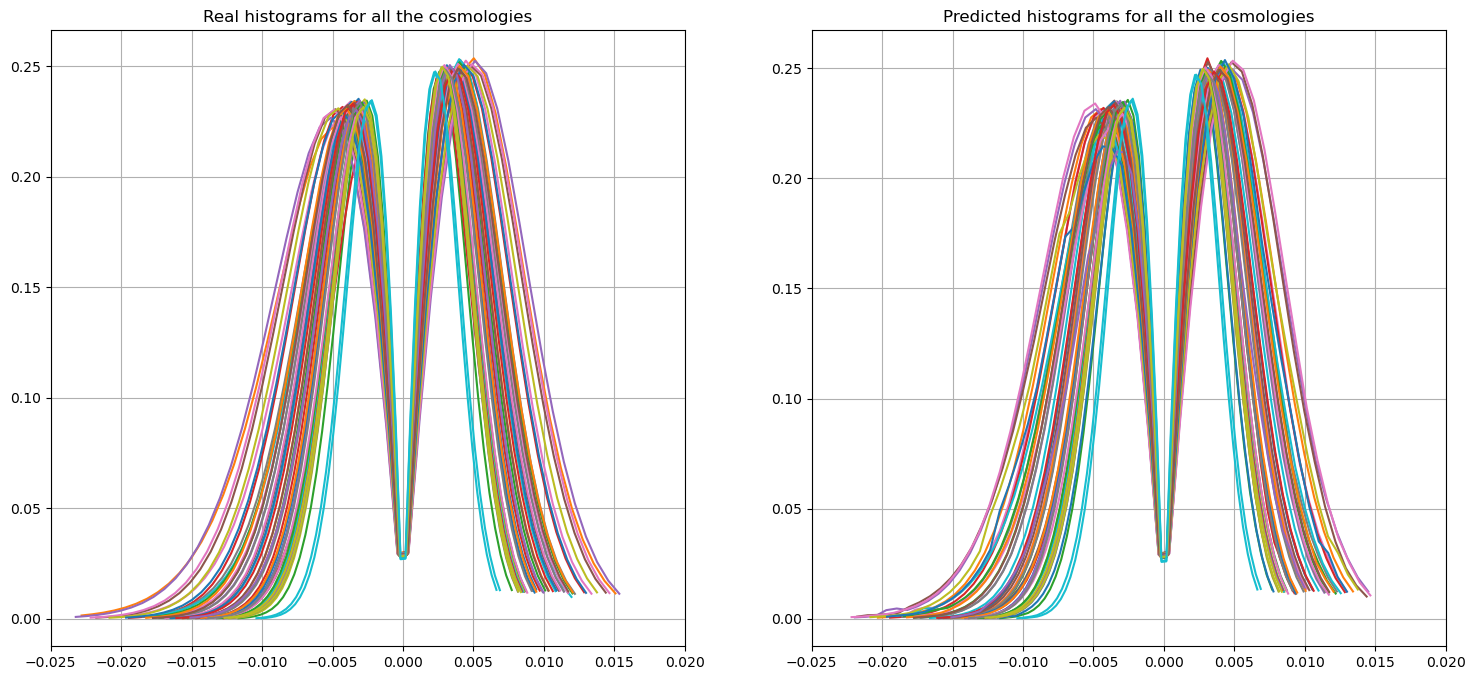

In [333]:
# plot in one subplot the real histograms for all the cosmologies and in another one the ones predicted by GPR
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)

for i in range(50):
    plt.plot(snr_rebinned[low_bin_cut:up_bin_cut] * np.sqrt(sigma_full[i]), Y_cut[i], label=f'{i}')

plt.xlim(-0.025, 0.02)
# plt.plot(fid_rebinned_mean[low_bin_cut:up_bin_cut], label='sim fid', color='black', linestyle='--')
plt.grid()
plt.title('Real histograms for all the cosmologies')

plt.subplot(1,2,2)
for i in range(50):
    test_cosmo = predict_l1norm(params_full[i])[0]
    kappa = snr_rebinned[low_bin_cut:up_bin_cut] * predict_sigma(params_full[i])[0]  
    plt.plot(kappa, test_cosmo, label=f'{i}')
plt.grid()
plt.xlim(-0.025, 0.02)
plt.title('Predicted histograms for all the cosmologies')

Text(0.5, 1.0, 'Predicted histograms for all the cosmologies')

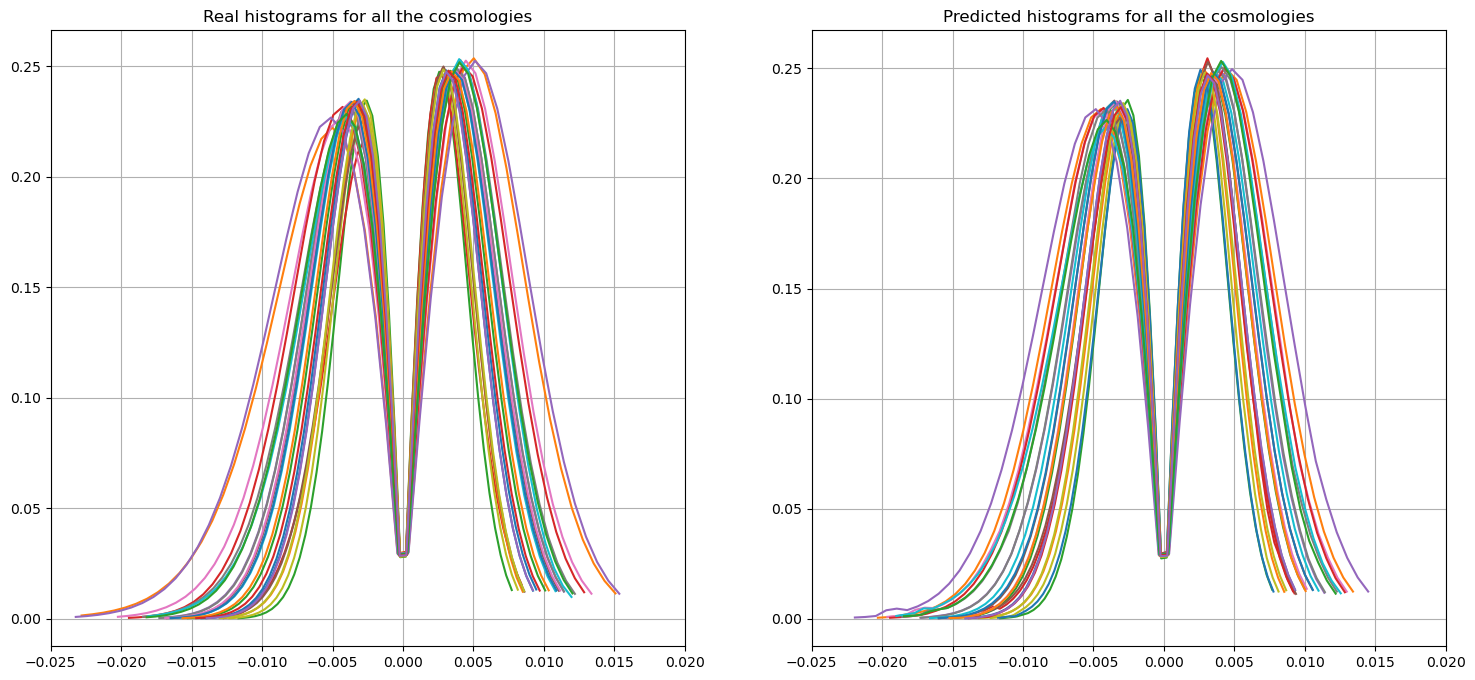

In [334]:
# plot in one subplot the real histograms for all the cosmologies and in another one the ones predicted by GPR
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)

for i in range(25):
    plt.plot(snr_rebinned[low_bin_cut:up_bin_cut] * np.sqrt(sigma_full[i]), Y_cut[i], label=f'{i}')

plt.xlim(-0.025, 0.02)
# plt.plot(fid_rebinned_mean[low_bin_cut:up_bin_cut], label='sim fid', color='black', linestyle='--')
plt.grid()
plt.title('Real histograms for all the cosmologies')

plt.subplot(1,2,2)
for i in range(25):
    test_cosmo = predict_l1norm(params_full[i])[0]
    kappa = snr_rebinned[low_bin_cut:up_bin_cut] * predict_sigma(params_full[i])[0]  
    plt.plot(kappa, test_cosmo, label=f'{i}')
plt.grid()
plt.xlim(-0.025, 0.02)
plt.title('Predicted histograms for all the cosmologies')